In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Preparing The Data

In [3]:
import pathlib
data_dir = pathlib.Path('data/train')

In [4]:
print(data_dir)

data\train


In [5]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 710 files belonging to 4 classes.
Using 426 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode="categorical",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 710 files belonging to 4 classes.
Using 142 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['stage-1', 'stage-2', 'stage-3', 'stage-4']


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization

# Training The Model


In [9]:
resnet_model = Sequential()

# Load the pretrained EfficientNetB6 model without the top layer
pretrained_model = tf.keras.applications.EfficientNetB6(include_top=False,
                   input_shape=(180, 180, 3),
                   pooling='avg',
                   weights='imagenet')

# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pretrained model to the sequential model
resnet_model.add(pretrained_model)

# Add a Flatten layer to flatten the output of the pretrained model
resnet_model.add(Flatten())

# Add additional Dense layers with BatchNormalization and Dropout for regularization
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(256, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))

resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dropout(0.5))

# Add the final Dense layer with the number of classes and softmax activation
resnet_model.add(Dense(4, activation='softmax'))  # Assuming there are 4 classes

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb6 (Functional)  (None, 2304)             40960143  
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                        

In [11]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
epochs=11
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
) 

Epoch 1/11
14/14 [==============================] - 56s 798ms/step - loss: 1.5961 - accuracy: 0.4789 - val_loss: 0.8814 - val_accuracy: 0.7324
Epoch 2/11
14/14 [==============================] - 3s 190ms/step - loss: 0.8634 - accuracy: 0.6948 - val_loss: 0.6006 - val_accuracy: 0.7817
Epoch 3/11
14/14 [==============================] - 3s 201ms/step - loss: 0.6179 - accuracy: 0.7535 - val_loss: 0.4433 - val_accuracy: 0.8239
Epoch 4/11
14/14 [==============================] - 3s 196ms/step - loss: 0.4616 - accuracy: 0.8404 - val_loss: 0.3641 - val_accuracy: 0.8592
Epoch 5/11
14/14 [==============================] - 3s 226ms/step - loss: 0.5911 - accuracy: 0.8005 - val_loss: 0.3204 - val_accuracy: 0.8803
Epoch 6/11
14/14 [==============================] - 3s 207ms/step - loss: 0.4079 - accuracy: 0.8545 - val_loss: 0.3412 - val_accuracy: 0.8732
Epoch 7/11
14/14 [==============================] - 3s 213ms/step - loss: 0.3972 - accuracy: 0.8779 - val_loss: 0.3044 - val_accuracy: 0.8662
Epoch

# Evaluating The Model

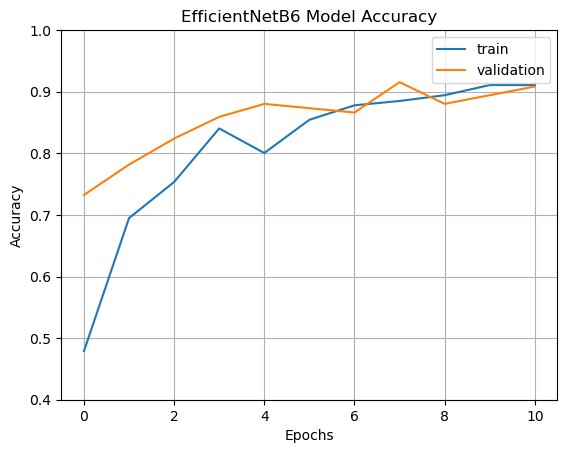

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('EfficientNetB6 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

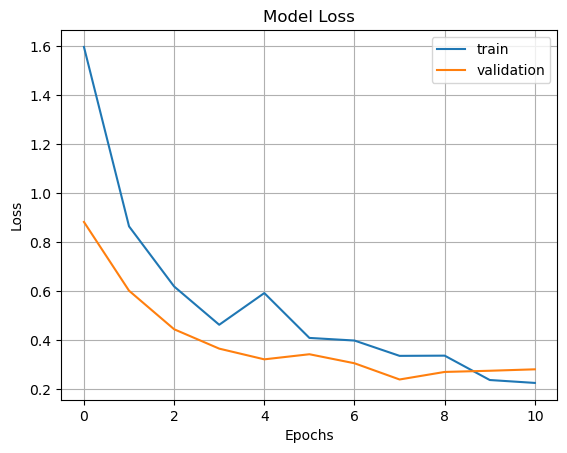

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# Making Predictions

(1, 180, 180, 3)


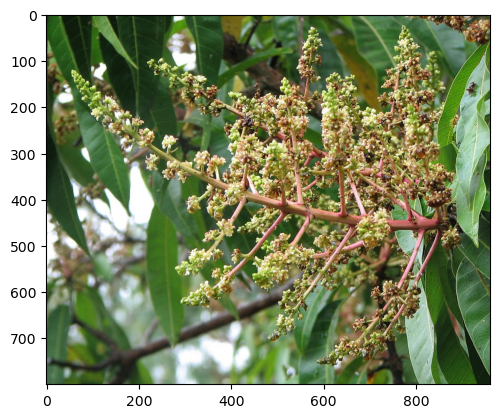

In [15]:
import cv2
image=cv2.imread('stage3.jpg')
image_resized= cv2.resize(image, (img_height,img_width))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
img=cv2.imread('stage3.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
pred=resnet_model.predict(image)
print(pred)

1/1 [==============================] - 6s 6s/step
[[0.01233402 0.05898382 0.9274343  0.00124792]]


In [17]:
output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

The predicted class is stage-3


1/1 [==============================] - 6s 6s/step


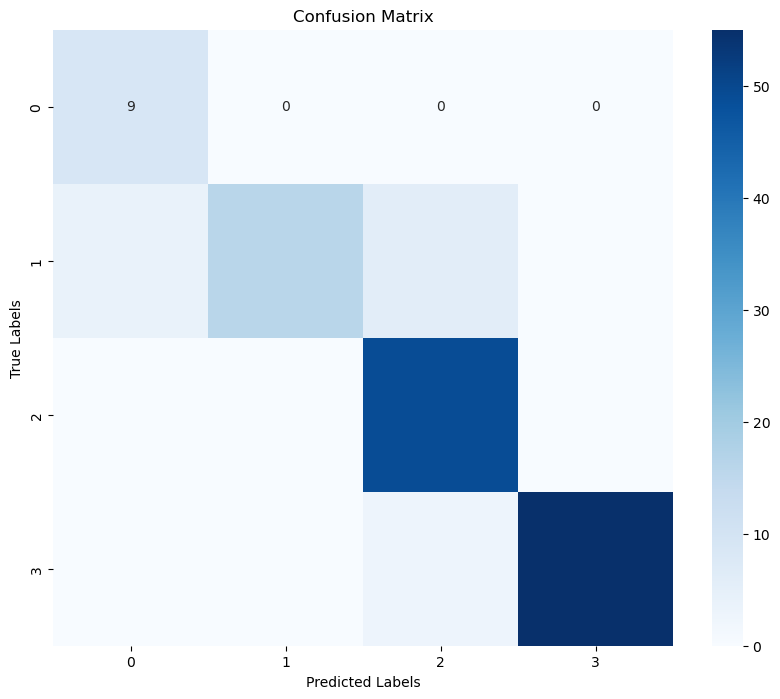

              precision    recall  f1-score   support

     stage-1       0.69      1.00      0.82         9
     stage-2       1.00      0.62      0.76        26
     stage-3       0.84      1.00      0.92        49
     stage-4       1.00      0.95      0.97        58

    accuracy                           0.91       142
   macro avg       0.88      0.89      0.87       142
weighted avg       0.93      0.91      0.91       142



In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels and predictions for the validation dataset
val_labels = []
val_predictions = []

for images, labels in val_ds:
    predictions = resnet_model.predict(images)
    val_labels.extend(np.argmax(labels.numpy(), axis=1))
    val_predictions.extend(np.argmax(predictions, axis=1))

val_labels = np.array(val_labels)
val_predictions = np.array(val_predictions)

# Compute the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
class_names = val_ds.class_names
print(classification_report(val_labels, val_predictions, target_names=class_names))